In [2]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.inspection import permutation_importance
from sklearn.metrics import root_mean_squared_error
from matplotlib.cm import viridis
from itertools import product
import optuna


In [3]:
# load static catchment attributes

glacier_attributes_dir = 'C:/Users/Justine Berg/Documents/ML-course/Project/data/static_attributes/CAMELS_CH_glacier_attributes.csv'
topographie_attributes_dir = 'C:/Users/Justine Berg/Documents/ML-course/Project/data/static_attributes/CAMELS_CH_topographic_attributes.csv'

glacier_attributes = pd.read_csv(glacier_attributes_dir, skiprows = 1, encoding='latin1')
topographie_attributes = pd.read_csv(topographie_attributes_dir, skiprows = 1, encoding='latin1')

In [4]:
# load in streamflow data

catchment = ['2019','2087','2109','2161','2219','2256','2268','2269','2469']
folder_path = 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow'

# Get all files in the folder
all_files = glob.glob(os.path.join(folder_path, 'CAMELS_CH_obs_based_*.csv'))
print(all_files)

['C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2004.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2007.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2009.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2011.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2014.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2016.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2017.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2018.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2019.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2020.csv', 'C:/Users

In [5]:
# Filter files based on gauging station IDs
filtered_files = [f for f in all_files if any(f'_{id}' in f for id in catchment)]
print("Filtered files:", filtered_files)

Filtered files: ['C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2019.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2087.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2109.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2161.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2219.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2256.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2268.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2269.csv', 'C:/Users/Justine Berg/Documents/ML-course/Project/data/streamflow\\CAMELS_CH_obs_based_2469.csv']


In [6]:
# read in streamflow data from all catchments

streamflow = []

for file in filtered_files:
    catchment_id = os.path.basename(file).split('_')[-1].replace('.csv', '')
    df = pd.read_csv(file, sep=';')
    df['catchment_id'] = catchment_id
    streamflow.append(df)

In [7]:
# Concatenate all DataFrames into a single DataFrame
streamflow_df = pd.concat(streamflow, ignore_index=True)
print(streamflow_df)

              date  discharge_vol(m3/s)  discharge_spec(mm/d)  waterlevel(m)  \
0       1981-01-01                8.034                 1.250        569.403   
1       1981-01-02                9.332                 1.452        569.469   
2       1981-01-03                7.705                 1.199        569.401   
3       1981-01-04               11.075                 1.724        569.549   
4       1981-01-05               13.668                 2.127        569.623   
...            ...                  ...                   ...            ...   
131485  2020-12-27                9.949                 1.752        646.405   
131486  2020-12-28                9.904                 1.744        646.404   
131487  2020-12-29                9.214                 1.622        646.390   
131488  2020-12-30                8.530                 1.502        646.376   
131489  2020-12-31                8.019                 1.412        646.366   

        precipitation(mm/d)  temperatur

In [8]:
# format date column
streamflow_df['date'] = pd.to_datetime(streamflow_df['date'])

# Handle missing values (if any)
streamflow_df.fillna(method='ffill', inplace=True)

C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_14192\1708744896.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  streamflow_df.fillna(method='ffill', inplace=True)


In [9]:
# Convert the gauge_id column to string in the glacier_attributes DataFrame
glacier_attributes['gauge_id'] = glacier_attributes['gauge_id'].astype(str)

# Convert the gauge_id column to string in the topographie_attributes DataFrame
topographie_attributes['gauge_id'] = topographie_attributes['gauge_id'].astype(str)


In [10]:
# filter attribute dataframes based on catchment IDs
filtered_glacier_attributes = glacier_attributes[glacier_attributes['gauge_id'].isin(catchment)]

filtered_topographie_attributes = topographie_attributes[topographie_attributes['gauge_id'].isin(catchment)]

In [11]:
# Rename columns to match
filtered_glacier_attributes = filtered_glacier_attributes.rename(columns={'gauge_id': 'catchment_id'})
filtered_topographie_attributes = filtered_topographie_attributes.rename(columns={'gauge_id': 'catchment_id'})

In [12]:
# Merge the filtered glacier attributes with the main DataFrame
streamflow_df = streamflow_df.merge(filtered_glacier_attributes[['catchment_id', 'glac_area']], on='catchment_id', how='left')

# Merge the filtered topography attributes with the main DataFrame
streamflow_df = streamflow_df.merge(filtered_topographie_attributes[['catchment_id', 'elev_mean','area','slope_mean']], on='catchment_id', how='left')

In [94]:
streamflow_df.set_index('date', inplace=True)
print(streamflow_df.head())

            discharge_vol(m3/s)  discharge_spec(mm/d)  waterlevel(m)  \
date                                                                   
1981-01-01                8.034                 1.250        569.403   
1981-01-02                9.332                 1.452        569.469   
1981-01-03                7.705                 1.199        569.401   
1981-01-04               11.075                 1.724        569.549   
1981-01-05               13.668                 2.127        569.623   

            precipitation(mm/d)  temperature_min(°C)  temperature_mean(°C)  \
date                                                                         
1981-01-01                 4.37               -11.59                 -7.91   
1981-01-02                17.89               -12.05                 -9.51   
1981-01-03                57.15                -8.07                 -5.17   
1981-01-04                40.59               -12.00                 -6.85   
1981-01-05                1

In [114]:
# Create dictionaries to store the splits for each catchment ID
train_dfs = {}
val_dfs = {}
test_dfs = {}

# Group by `catchment_id` and split each group separately
for catchment_id, group_df in streamflow_df.groupby('catchment_id'):
    # Ensure each group is sorted by date for correct chronological splitting
    group_df = group_df.sort_index()
    
    # Define date ranges for this group
    train_end = '2000-12-31'
    val_end = '2010-12-31'
    
    # Split based on the date ranges
    train_dfs[catchment_id] = group_df.loc[:train_end]
    val_dfs[catchment_id] = group_df.loc[train_end:val_end]
    test_dfs[catchment_id] = group_df.loc[val_end:]

In [115]:
# Display the sizes to verify each split for this catchment
print(f"Catchment {catchment_id} - Training set:", train_dfs[catchment_id].shape)
print(f"Catchment {catchment_id} - Validation set:", val_dfs[catchment_id].shape)
print(f"Catchment {catchment_id} - Test set:", test_dfs[catchment_id].shape)

Catchment 2469 - Training set: (7305, 14)
Catchment 2469 - Validation set: (3653, 14)
Catchment 2469 - Test set: (3654, 14)


In [97]:
# Concatenate each dictionary into a single dataframe with a catchment_id column
train_df = pd.concat([df.assign(catchment_id=catchment_id) for catchment_id, df in train_dfs.items()])
val_df = pd.concat([df.assign(catchment_id=catchment_id) for catchment_id, df in val_dfs.items()])
test_df = pd.concat([df.assign(catchment_id=catchment_id) for catchment_id, df in test_dfs.items()])

In [117]:
print(test_dfs[catchment_id].shape)

(3654, 14)


In [118]:
# Extract column names
column_names = train_df.columns
print(train_df.columns)

Index(['discharge_vol(m3/s)', 'discharge_spec(mm/d)', 'waterlevel(m)',
       'precipitation(mm/d)', 'temperature_min(°C)', 'temperature_mean(°C)',
       'temperature_max(°C)', 'rel_sun_dur(%)', 'swe(mm)', 'catchment_id',
       'glac_area', 'elev_mean', 'area', 'slope_mean'],
      dtype='object')


In [119]:
# Normalize the features
scaler = StandardScaler()

In [120]:
# Fit and transform the training data
train_scaled = scaler.fit_transform(train_df)

# Transform the validation and test data
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [121]:
# Create a new DataFrame with the scaled data and reassign column names
train_scaled_df = pd.DataFrame(train_scaled, columns=column_names, index=train_df.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=column_names, index=val_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=column_names, index=test_df.index)

In [122]:
print(train_scaled_df.head())

            discharge_vol(m3/s)  discharge_spec(mm/d)  waterlevel(m)  \
date                                                                   
1981-01-01            -0.247311             -0.638006      -1.362813   
1981-01-02            -0.172149             -0.603060      -1.362671   
1981-01-03            -0.266363             -0.646829      -1.362817   
1981-01-04            -0.071218             -0.556003      -1.362498   
1981-01-05             0.078934             -0.486283      -1.362338   

            precipitation(mm/d)  temperature_min(°C)  temperature_mean(°C)  \
date                                                                         
1981-01-01            -0.045323            -1.162977             -1.065954   
1981-01-02             1.349091            -1.230839             -1.296236   
1981-01-03             5.398255            -0.643681             -0.671595   
1981-01-04             3.690304            -1.223463             -0.913392   
1981-01-05             0.61

In [103]:
# define sequence length - decided on half a year
sequence_length = 182
window_size = sequence_length

In [123]:
train_X = np.lib.stride_tricks.sliding_window_view(train_scaled_df[['precipitation(mm/d)','temperature_min(°C)','temperature_mean(°C)',
                                                                  'temperature_max(°C)','rel_sun_dur(%)','glac_area','elev_mean','area',
                                                                  'slope_mean']].values,
                                                   window_size,
                                                   axis=0) 

val_X = np.lib.stride_tricks.sliding_window_view(val_scaled_df[['precipitation(mm/d)','temperature_min(°C)','temperature_mean(°C)',
                                                                  'temperature_max(°C)','rel_sun_dur(%)','glac_area','elev_mean','area',
                                                                  'slope_mean']].values, 
                                                 window_size, 
                                                 axis=0) 

test_X = np.lib.stride_tricks.sliding_window_view(test_scaled_df[['precipitation(mm/d)','temperature_min(°C)','temperature_mean(°C)',
                                                                  'temperature_max(°C)','rel_sun_dur(%)','glac_area','elev_mean','area',
                                                                  'slope_mean']].values, 
                                                  window_size, 
                                                  axis=0) 

In [124]:
train_X = np.moveaxis(train_X, 1, 2)  

val_X = np.moveaxis(val_X, 1, 2)  

test_X = np.moveaxis(test_X, 1, 2)

In [125]:
train_y = train_df['discharge_vol(m3/s)'].values[window_size-1:]  
val_y = val_df['discharge_vol(m3/s)'].values[window_size-1:]    
test_y = test_df['discharge_vol(m3/s)'].values[window_size-1:]

In [126]:
print(f'Train Shape:      X:{train_X.shape}, y:{train_y.shape}',
      f'Validation Shape: X:{val_X.shape}, y:{val_y.shape}',
      f'Test Shape:       X:{test_X.shape}, y:{test_y.shape}', 
      sep='\n')

Train Shape:      X:(65564, 182, 9), y:(65564,)
Validation Shape: X:(32696, 182, 9), y:(32696,)
Test Shape:       X:(32705, 182, 9), y:(32705,)


In [127]:
#@title Run this cell to check if a GPU is available. We'll use a variable called `calc_device` to store either the cpu or gpu to run calculations on. 
if torch.cuda.device_count()>0:
  calc_device = torch.device('cuda:0')
else:
  calc_device = torch.device('cpu')

In [128]:
# Convert numpy arrays into tensors and send them to the appropriate device
train_Xtensor = torch.FloatTensor(train_X.copy()).to(calc_device)
train_ytensor = torch.FloatTensor(train_y.copy()).to(calc_device)

val_Xtensor = torch.FloatTensor(val_X.copy()).to(calc_device)
val_ytensor = torch.FloatTensor(val_y.copy()).to(calc_device)

test_Xtensor = torch.FloatTensor(test_X.copy()).to(calc_device)
test_ytensor = torch.FloatTensor(test_y.copy()).to(calc_device)

In [129]:
# And group them into a dataset using the TensorDataset utility
train_data = TensorDataset(train_Xtensor, train_ytensor)
val_data = TensorDataset(val_Xtensor, val_ytensor)
test_data = TensorDataset(test_Xtensor, test_ytensor)

In [130]:
print(f'X tensor size (train): {train_Xtensor.size()}',
      f'X tensor size (val): {train_Xtensor.size()}',
      f'X tensor size (test): {train_Xtensor.size()}\n',
      sep='\n')

X tensor size (train): torch.Size([65564, 182, 9])
X tensor size (val): torch.Size([65564, 182, 9])
X tensor size (test): torch.Size([65564, 182, 9])



In [34]:
# Define the MyLSTM class which extends nn.Module
class MyLSTM(nn.Module):  # Define the class which we're extending using our MyLSTM class
    # Begin by defining the initialization function for our class
    def __init__(self,  # The first argument to the class in all methods is itself 
                 input_size,  # Model Hyperparameter 1: Number of input features
                 hidden_size): # Model Hyperparameter 2: Number of LSTM cells per layer
        
        # Call the superclass initializer
        super(MyLSTM, self).__init__()

        # Store the hyperparameters passed into the class during initialization
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define the LSTM layer
        self.LSTM_layer = nn.LSTM(  # Let's instantiate the PyTorch LSTM module 
            input_size=self.input_size,  # The number of features in the input series
            hidden_size=self.hidden_size,  # The number of LSTM cells per layer
            num_layers=1,  # The number of LSTM Layers (set to 1 for simplicity, can be adjusted)
            bias=True,  # Enable the use of biases
            batch_first=True  # Let the layer know the input shape is (batch_size, series_len, num_features) 
        )

        # Define the Dropout Layer
        self.dropout_layer = nn.Dropout(  # Instantiate the PyTorch dropout layer
            p=0.5  # Set the dropout rate (can adjust as needed)
        )

        # Define the output layer - we'll make a linear aggregation of the LSTM outputs 
        self.out_layer = nn.Linear(  # Instantiate the PyTorch linear layer
            in_features=self.hidden_size,  # Number of inputs
            out_features=1  # Number of predictions per number of inputs (assuming a single output)
        )
        
    # Define the forward pass
    def forward(self, X):
        
        # Calculate the LSTM output, hidden state, and memory cell
        output, (h_n, c_n) = self.LSTM_layer(X)  # Forward pass through LSTM
        
        # Calculate our model's hidden state from the last hidden state of the LSTM
        # using our dropout layer
        hidden_state = self.dropout_layer(h_n[-1])  # Use the last hidden state from the last layer

        # Make the prediction by using the ReLU activation on the dense layer output
        p_hat = torch.flatten(torch.relu(self.out_layer(hidden_state)))  # Flattening the output
        return p_hat  # Return the prediction

In [ ]:
def calc_nse(sim: torch.FloatTensor, obs: torch.FloatTensor, global_obs_mean: torch.FloatTensor) -> float:
    """Calculate the Nash-Sutcliff-Efficiency coefficient.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :param global_obs_mean: mean of the whole observation series
    :return: NSE value.
    """
    numerator = torch.square(sim - obs).sum()
    denominator = torch.square(obs - global_obs_mean).sum()
    nse_val = 1 - numerator / denominator

    return nse_val

In [36]:
# Define the loss function for training 
loss_func = nn.MSELoss()  # Mean Squared Error loss for regression tasks

# Define the number of epochs
num_epochs = 100  # Set the number of epochs for training (can adjust based on needs)

In [37]:
def eval_model(model,  # the model to be evaluated
               dataloader,  # the dataloader for the dataset used for the evaluation
               loss_func,  # the main loss function to be used 
               metric_func):  # the function to be used as a performance metric
    # Tell pytorch that we don't need to keep track of the gradients
    # After all, gradients are only used during training.

    with torch.no_grad():       
        # Zero the loss and the metric
        loss = 0
        metric = 0

        # We'll start by calculating the mean of the whole dataset
        # This will be used in the NSE coefficient calculation
        
        # Start by defining a placeholder variable for the sum of the 
        # observations, and another for the number of datapoints in the set
        global_sum = 0
        label_size = 0

        # Iterate through the features and labels in the dataloader
        for features, labels in dataloader:
            # add the sum of the labels to the global sum
            global_sum += labels.sum()

            # Keep track of how many labels we've seen
            label_size += len(labels) 
        
        # Calculate the mean of the observations using the information gathered
        global_mean = global_sum / label_size

        # Iterate through the features and labels in the dataloader, this time
        # for evaluating the model
        for features, labels in dataloader:
            # get predictions from the model using the features in the batch
            predictions = model(features)

            # calculate the batch loss
            batch_loss = loss_func(predictions, labels)

            # calculate the batch metric
            batch_metric = metric_func(predictions, labels, global_mean)

            # Keep track of the loss and metric. Remember to convert them from 
            # pytorch tensors to scalars
            loss += batch_loss.item()
            metric += batch_metric.item()
        
        # Calculate the number of batches in the dataloader
        num_batches = len(dataloader)

        # Calculate the mean loss
        loss = loss / num_batches
        metric = metric / num_batches
        
        return (loss, metric)

In [ ]:
# run for optimizing the hyperparameters

def objective(trial):
    # Define hyperparameter space
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # Learning rate in log-uniform space
    hidden_size = trial.suggest_int("hidden_size", 16, 64, step=4)  # Hidden size in steps of 4
    batch_size = trial.suggest_int("batch_size", 16, 128, step=16)  # Batch size in steps of 16
    
    # Update dataloaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
    
    # Initialize model and optimizer
    model = MyLSTM(input_size=9, hidden_size=hidden_size).to(calc_device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    train_losses = []
    val_NSEs = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            pred = model(features)
            batch_loss = loss_func(pred, labels)
            batch_loss.backward()
            optimizer.step()
            train_loss += batch_loss.item()
        train_loss /= len(train_loader)
        
        val_loss, val_NSE = eval_model(model, val_loader, loss_func, calc_nse)
        val_NSEs.append(val_NSE)
    
    # Return the best NSE (maximize metric)
    return max(val_NSEs)

# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best hyperparameters:", study.best_params)

[I 2024-11-29 23:31:27,091] A new study created in memory with name: no-name-aad8bef2-e130-4ff3-8182-15bebd69d949


C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\4106960952.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)  # Learning rate in log-uniform space
[I 2024-11-30 00:55:02,892] Trial 0 finished with value: 0.8717914328598452 and parameters: {'lr': 0.0003138718410309938, 'hidden_size': 60, 'batch_size': 80}. Best is trial 0 with value: 0.8717914328598452.
[I 2024-11-30 01:29:58,541] Trial 1 finished with value: 0.808952030253737 and parameters: {'lr': 0.0006499327264038256, 'hidden_size': 20, 'batch_size': 64}. Best is trial 0 with value: 0.8717914328598452.
[I 2024-11-30 01:50:53,750] Trial 2 finished with value: 0.8315669590071456 and parameters: {'lr': 0.0024508165887779185, 'hidden_size': 16, 'batch_size': 112}. Best is trial 0 with value: 0.8717914328598452.
[I 2024-1

Best hyperparameters: {'lr': 0.0012498299278836187, 'hidden_size': 56, 'batch_size': 128}


In [ ]:
best_params = study.best_params

# Extract values and assign them to separate variables
lr = best_params['lr']
hidden_size = best_params['hidden_size']
batch_size = best_params['batch_size']

In [39]:
# manual writing of bets hyperparametr set

lr = 0.0012498299278836187
hidden_size = 56
batch_size = 128


In [56]:
# Define the loss function for training 
loss_func = nn.MSELoss()  # Mean Squared Error loss for regression tasks

# Instantiate our LSTM model
model = MyLSTM(input_size=9,  # Hyperparameter 1: Set to the number of input features (e.g., 10)
               hidden_size=hidden_size,  # Hyperparameter 2: Number of LSTM units (set to 16 as mentioned)
               ).to(calc_device)  # Make sure the model is on the same device as the Tensors 

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(),  # We need to pass the parameters the optimizer will optimize
                             lr=lr)  # Learning rate for the optimizer (default value)

# Define the number of epochs
num_epochs = 100  # Set the number of epochs for training (can adjust based on needs)

In [57]:
train_loader = DataLoader(
    dataset=train_data,          # Define the dataset to use
    batch_size=batch_size,       # Set the batch size
    shuffle=True                 # Shuffling is necessary for training
)

val_loader = DataLoader(
    dataset=val_data,            # Define the dataset to use
    batch_size=batch_size,       # Set the batch size
    shuffle=False                # No shuffling for validation
)

test_loader = DataLoader(
    dataset=test_data,           # Define the dataset to use
    batch_size=batch_size,       # Set the batch size
    shuffle=False                # No shuffling for testing
)

In [44]:
# Define empty lists that will be used to keep track of the training losses,
# validation losses, and validation metrics  
train_losses = []
val_losses = []
train_NSEs = []
val_NSEs = []

# Calculate the global mean of the observations for the entire training dataset
global_obs_mean = torch.cat([labels for _, labels in train_loader]).mean()

for epoch in range(num_epochs):  # Loop over the number of epochs
    # Zero the training loss
    train_loss = 0
    all_train_preds = []
    all_train_labels = []

    # Iterate through the features and labels in the train dataloader 
    for features, labels in train_loader:
        # We need to zero the gradients associated with the model parameters.
        # We can do this directly using the optimizer
        optimizer.zero_grad()

        # Get predictions from the features using the model
        pred = model(features)

        # And use the predictions to calculate the batch loss
        batch_loss = loss_func(pred, labels)

        # Do the backpropagation from the batch_loss
        batch_loss.backward()

        # Step through the optimizer
        optimizer.step()

        # Keep track of the train loss sum. 
        # Remember to turn the tensor into a scalar!
        train_loss += batch_loss.item()

        # Collect all predictions and labels for NSE calculation
        all_train_preds.append(pred.detach())
        all_train_labels.append(labels.detach())

    # Calculate the number of batches in the training dataloader
    num_batches = len(train_loader)

    # Get the mean training loss over the batches
    train_loss = train_loss / num_batches

    # Concatenate all predictions and labels
    all_train_preds = torch.cat(all_train_preds)
    all_train_labels = torch.cat(all_train_labels)

    # Calculate training NSE
    train_NSE = calc_nse(all_train_labels, all_train_preds, global_obs_mean)

    # And append it into the list we defined to keep track of the loss and NSE
    train_losses.append(train_loss)
    train_NSEs.append(train_NSE)
    
    # Calculate the validation loss and metric.
    # Use the function we defined before!
    val_loss, val_NSE = eval_model(model,  # The model
                                    val_loader,  # The dataloader
                                    loss_func,  # The loss function
                                    calc_nse)  # Replace with the actual metric function

    # Append the metric and loss values into the lists we made to keep track
    val_losses.append(val_loss)
    val_NSEs.append(val_NSE)


    # We want to save the model if it's the best version of it we've found
    # during training. If the NSE coefficient is the maximum in our training 
    # history, we'll go ahead and save the model as our best model.
    if val_NSE >= max(val_NSEs):
        torch.save(model, './best_model.pt')

    # And print out a statement to keep track of our training as we iterate
    print(f'\rEpoch: {epoch + 1}/{num_epochs},'  # Current epoch, total number of epochs
          f'train_loss: {train_loss:.4f},'  # training loss we found this epoch
          f'train_NSE: {train_NSE:.4f},'  # training NSE we found this epoch
          f'val_loss: {val_loss:.4f},'  # validation loss we found this epoch
          f'val_NSE: {val_NSE:.4f}',  # validation NSE we found this epoch
          end="")
 

Epoch: 100/100,train_loss: 15.6307,train_NSE: 0.9455,val_loss: 29.2253,val_NSE: 0.8815

In [45]:
#@title Run this cell to load the best model from our training before we evaluate the performance.
model = torch.load( './best_model.pt')

C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_36396\4184973520.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load( './best_model.pt')


In [49]:
model.eval()  # Set the model to evaluation mode

# Find the index of the best NSE
best_index = val_NSEs.index(max(val_NSEs))

# Get the best metrics
best_train_loss = train_losses[best_index]
best_val_loss = val_losses[best_index]
best_val_NSE = val_NSEs[best_index]

# Print the best metrics
print("\nBest Run:")
print(f'train_loss: {best_train_loss:.4f},'
      f'val_loss: {best_val_loss:.4f},'
      f'NSE: {best_val_NSE:.4f}')


Best Run:
train_loss: 18.7096,val_loss: 27.7999,NSE: 0.9001


In [1]:
#@title Run this cell to load the best model from our training before we evaluate the performance.
model = torch.load( './best_model.pt')

NameError: name 'torch' is not defined

In [48]:
# Assuming test_Xtensor and test_ytensor are your test input and target tensors
with torch.no_grad():
    test_predictions = model(test_Xtensor)

# Calculate the loss
test_loss = loss_func(test_predictions, test_ytensor).item()

# Define the NSE calculation function
def calc_nse(observed, predicted):
    observed_mean = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - observed_mean) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

# Convert tensors to numpy arrays for NSE calculation
test_ytensor_np = test_ytensor.numpy()
test_predictions_np = test_predictions.numpy()

# Calculate NSE
test_nse = calc_nse(test_ytensor_np, test_predictions_np)

# Print the test loss and NSE
print(f'Test Loss: {test_loss:.4f}')
print(f'Test NSE: {test_nse:.4f}')

RuntimeError: input.size(-1) must be equal to input_size. Expected 10, got 9

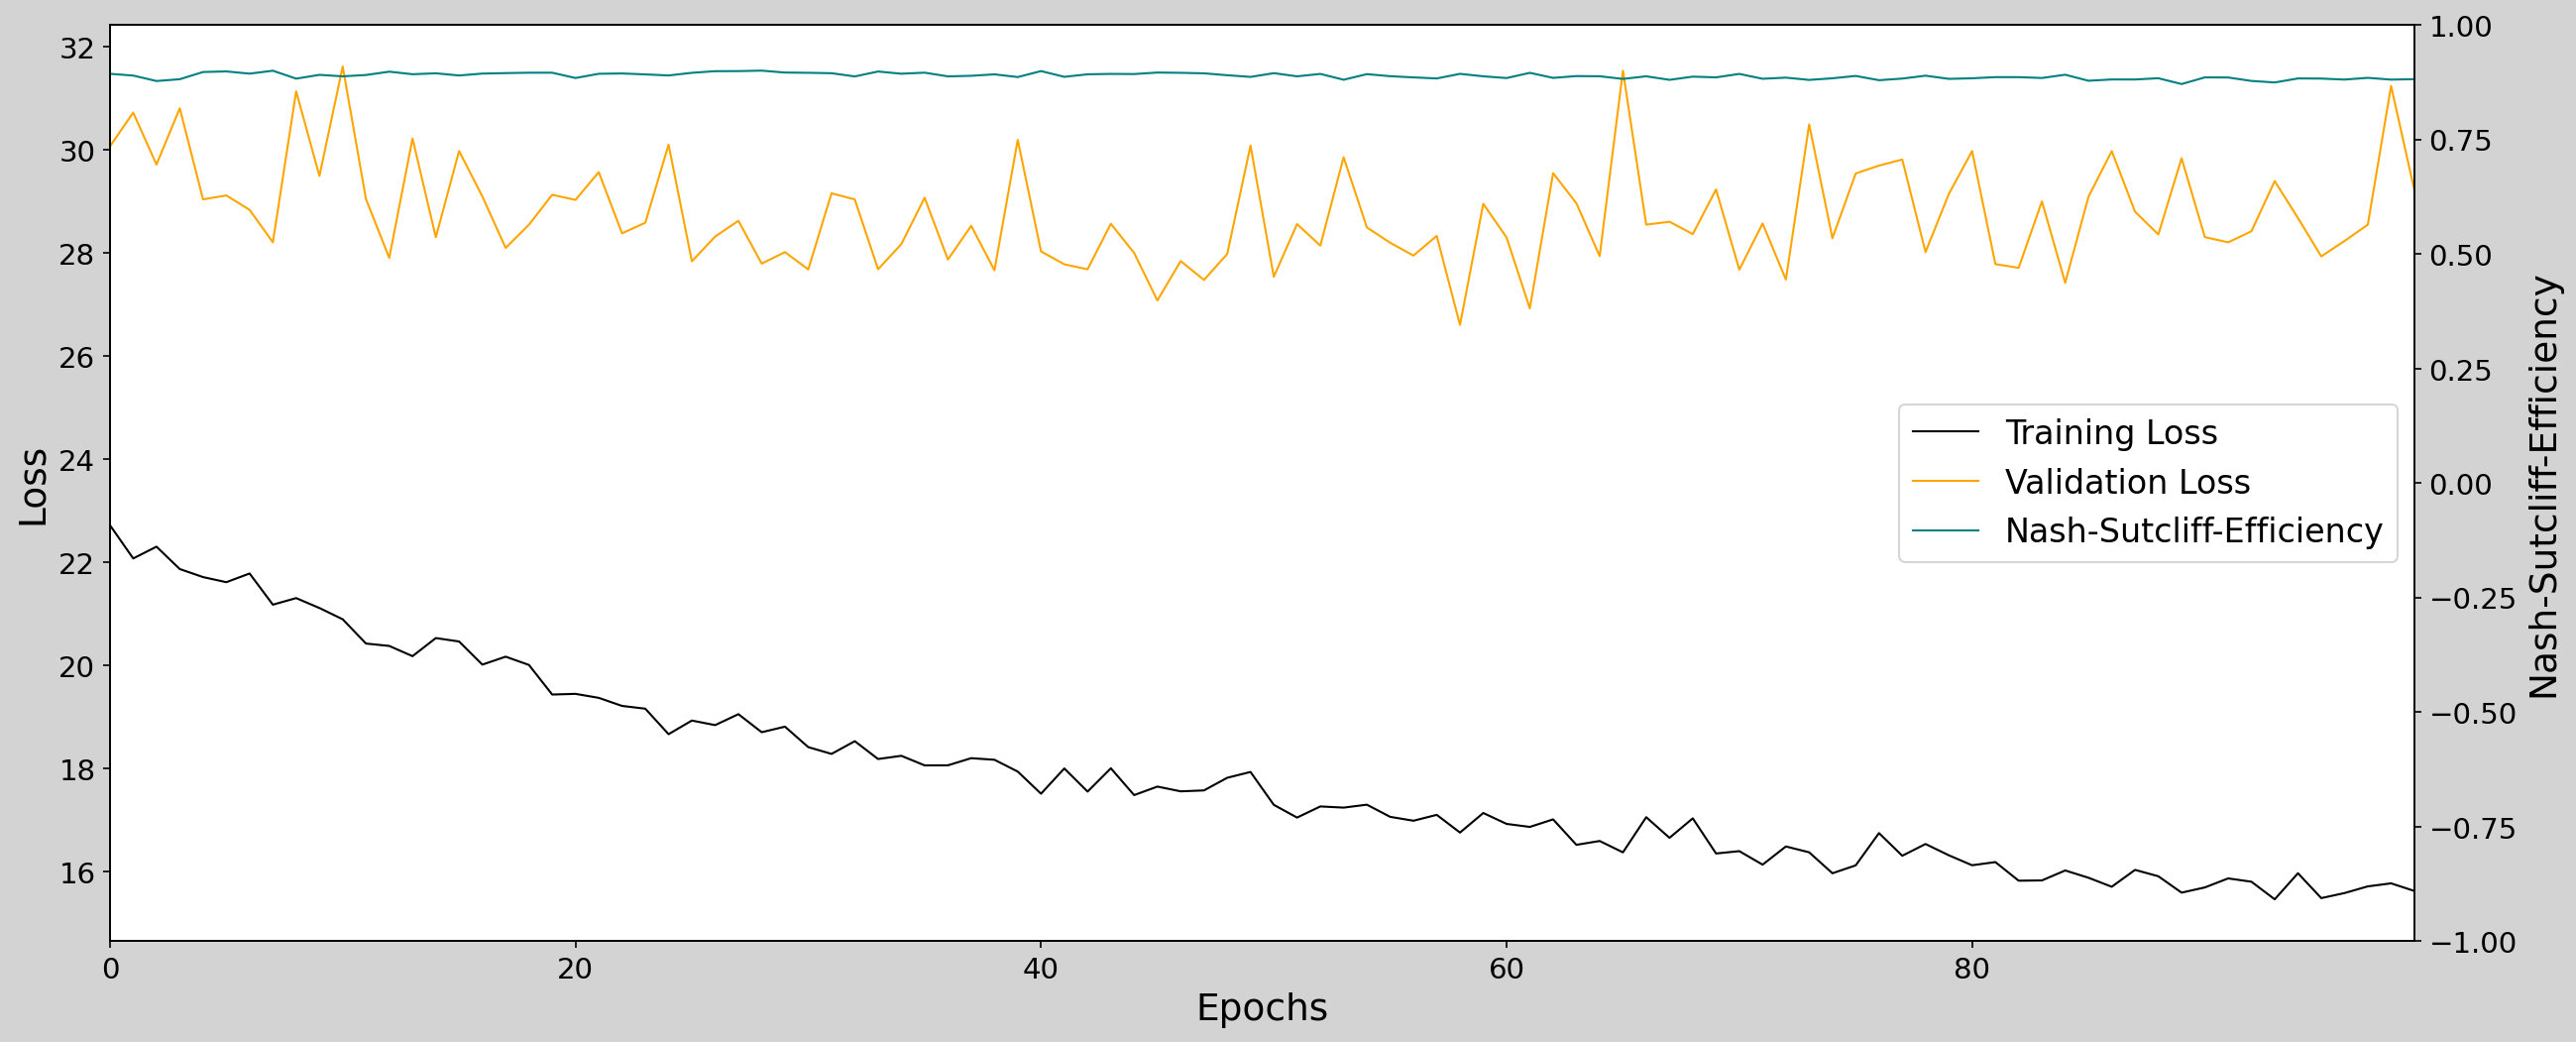

In [51]:
# Plotting out the Training and Validation performance. We'll use 
# torch.no_grad() since we don't need to calculate the gradients for
# plotting
# Plotting out the Training and Validation performance
with torch.no_grad():
    fig, ax = plt.subplots(figsize=(20, 8), dpi=150)
    
    # Plot the training losses
    train_loss_line, = ax.plot(train_losses,
                               c='black', 
                               linewidth=1,
                               label='Training Loss')
    
    # Plot the validation losses
    val_loss_line, = ax.plot(val_losses,
                             c='orange', 
                             linewidth=1,
                             label='Validation Loss')
    
    # Copy
    metric_ax = ax.twinx()
    nse_line, = metric_ax.plot(val_NSEs,
                               c='teal', 
                               linewidth=1,
                               label='Nash-Sutcliff-Efficiency')
    metric_ax.set_ylim([-1, 1])
    metric_ax.set_yticks(np.arange(-1, 1.01, 0.25))
    ax.autoscale(enable=True, axis='x', tight=True)
    
    # Set axis labels with larger font size
    ax.set_xlabel('Epochs', fontsize=18)
    ax.set_ylabel('Loss', fontsize=18)
    metric_ax.set_ylabel('Nash-Sutcliff-Efficiency', fontsize=18)
    
    # Increase the font size of the axis tick labels
    ax.tick_params(axis='both', which='major', labelsize=14)
    metric_ax.tick_params(axis='y', which='major', labelsize=14)
    
    # Combine legends from both axes
    lines = [train_loss_line, val_loss_line, nse_line]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc='center right', fontsize=16)
    
    fig.set_facecolor('lightgrey')
    plt.show()

C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\113212739.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_test_ytensor = test_ytensor[mask]
C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\113212739.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_test_Xtensor = test_Xtensor[mask]


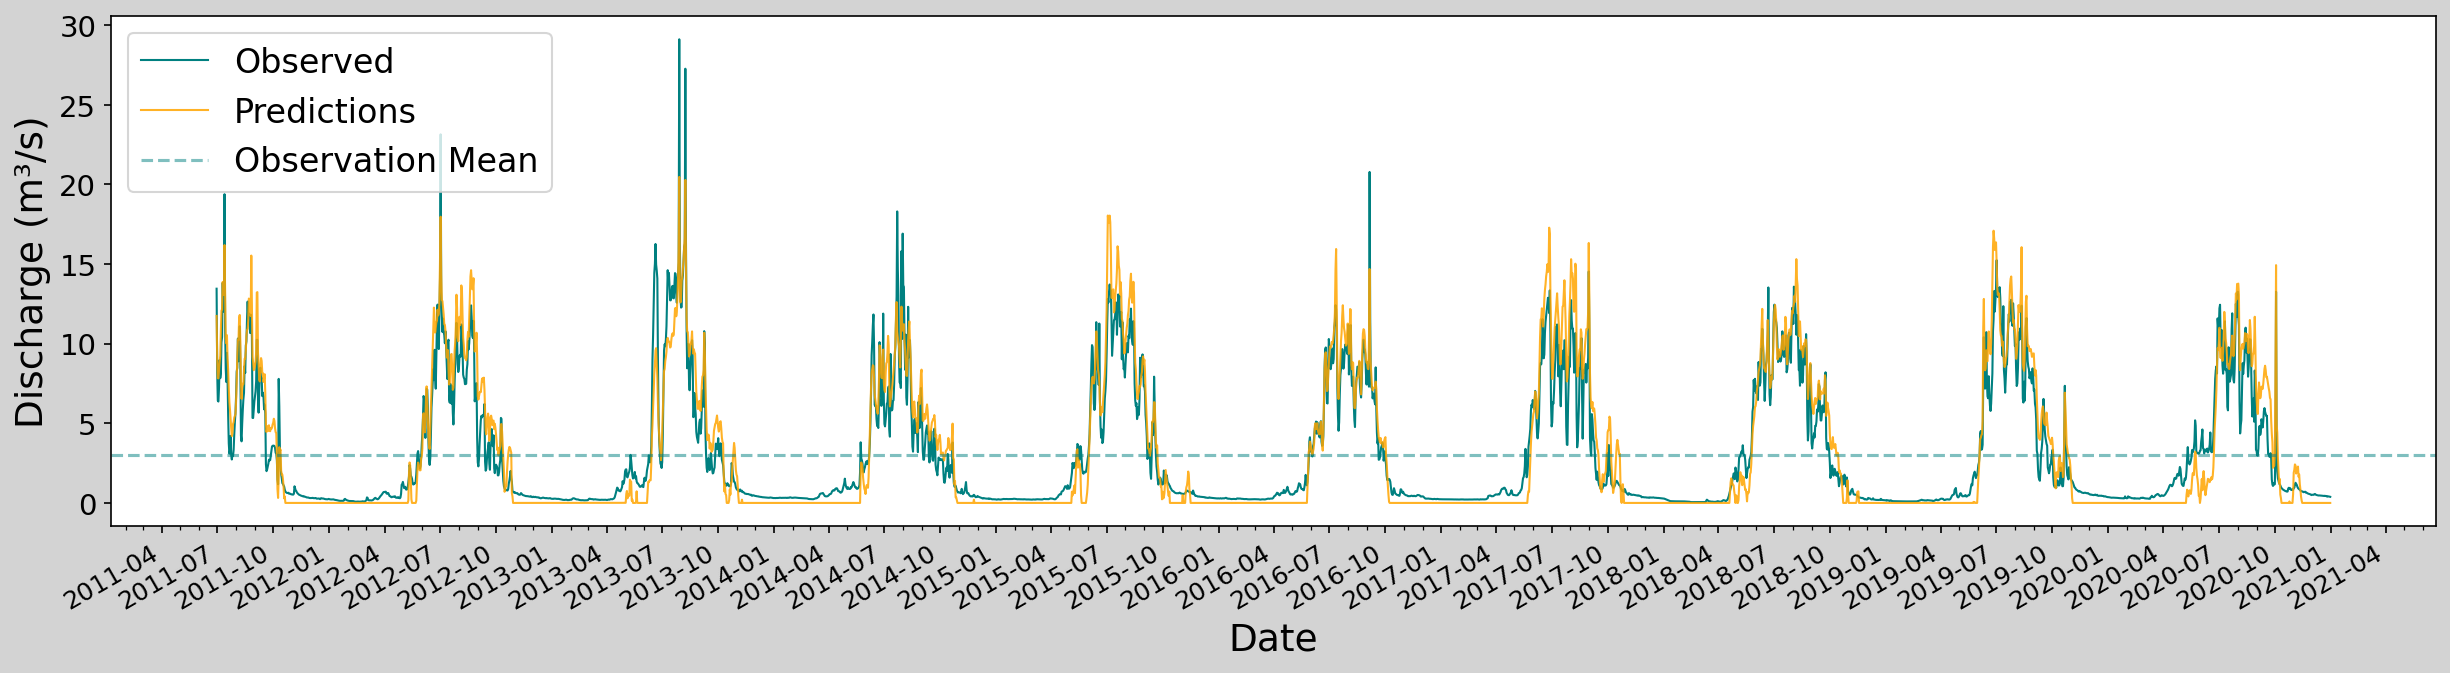

In [267]:
# Ensure the indices of test_df and test_final_df are aligned
#test_df = test_df.reset_index(drop=True)
#test_final_df = test_df.reset_index(drop=True)

# Add the catchment_id column from test_df to test_final_df
#test_final_df['catchment_id'] = test_df['catchment_id']

# Ensure the shapes match by filtering test_final_df to match the tensor shapes
test_df = test_df.iloc[:test_ytensor.shape[0]]

# Specify the catchment_id you want to plot
desired_catchment_id = '2268'

# Filter the DataFrame to include only the desired time series
filtered_test_df = test_df[test_df['catchment_id'] == desired_catchment_id]

# Create a boolean mask for the desired catchment_id
mask = test_df['catchment_id'] == desired_catchment_id

# Use the boolean mask to filter the tensors
filtered_test_ytensor = test_ytensor[mask]
filtered_test_Xtensor = test_Xtensor[mask]

# Adjust the index for plotting
plot_index = filtered_test_df.index[window_size-1:]

# Ensure the lengths match
filtered_test_ytensor = filtered_test_ytensor[:len(plot_index)]
filtered_test_Xtensor = filtered_test_Xtensor[:len(plot_index)]

# Plotting the filtered time series
test_obs_mean = torch.mean(filtered_test_ytensor)
with torch.no_grad():
    fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
    ax.plot(plot_index, 
            filtered_test_ytensor.cpu().numpy(),
            c='teal', 
            linewidth=1,
            label='Observed')
    ax.plot(plot_index, 
            model(filtered_test_Xtensor).cpu().numpy(), 
            c='orange', 
            alpha=0.85, 
            linewidth=1,
            label='Predictions')
    ax.axhline(filtered_test_ytensor.mean().item(), color='teal', alpha=0.5, linestyle='--', label='Observation Mean')
    
    # Format the x-axis to show dates with less frequent labels
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show labels every 3 months
    ax.xaxis.set_minor_locator(mdates.MonthLocator())  # Minor ticks every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    fig.autofmt_xdate()
    
    # Set axis labels with larger font size
    ax.set_xlabel('Date', fontsize=18)
    ax.set_ylabel('Discharge (m³/s)', fontsize=18)
    
    # Increase the font size of the axis tick labels
    ax.tick_params(axis='x', which='major', labelsize=12)  # Adjusted to 12 for smaller x-axis tick labels
    ax.tick_params(axis='y', which='major', labelsize=14)  # Keep y-axis tick labels at 14
    
    # Set legend with larger font size and move to top left corner
    ax.legend(loc='upper left', fontsize=16)
    
    fig.set_facecolor('lightgrey')
    plt.show()

Initial lengths:
filtered_test_df: 3654
filtered_test_Xtensor: 3473
filtered_test_ytensor: 3473
Lengths after ensuring match:
filtered_test_df: 3473
filtered_test_Xtensor: 3473
filtered_test_ytensor: 3473
Length of predicted_discharge: 3473
Length of predicted_discharge after ensuring match: 3473


C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\2440331201.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_df.loc[:, 'predicted_discharge'] = predicted_discharge
C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\2440331201.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_test_df['year'] = filtered_test_df['date'].dt.year
C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\2440331201.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

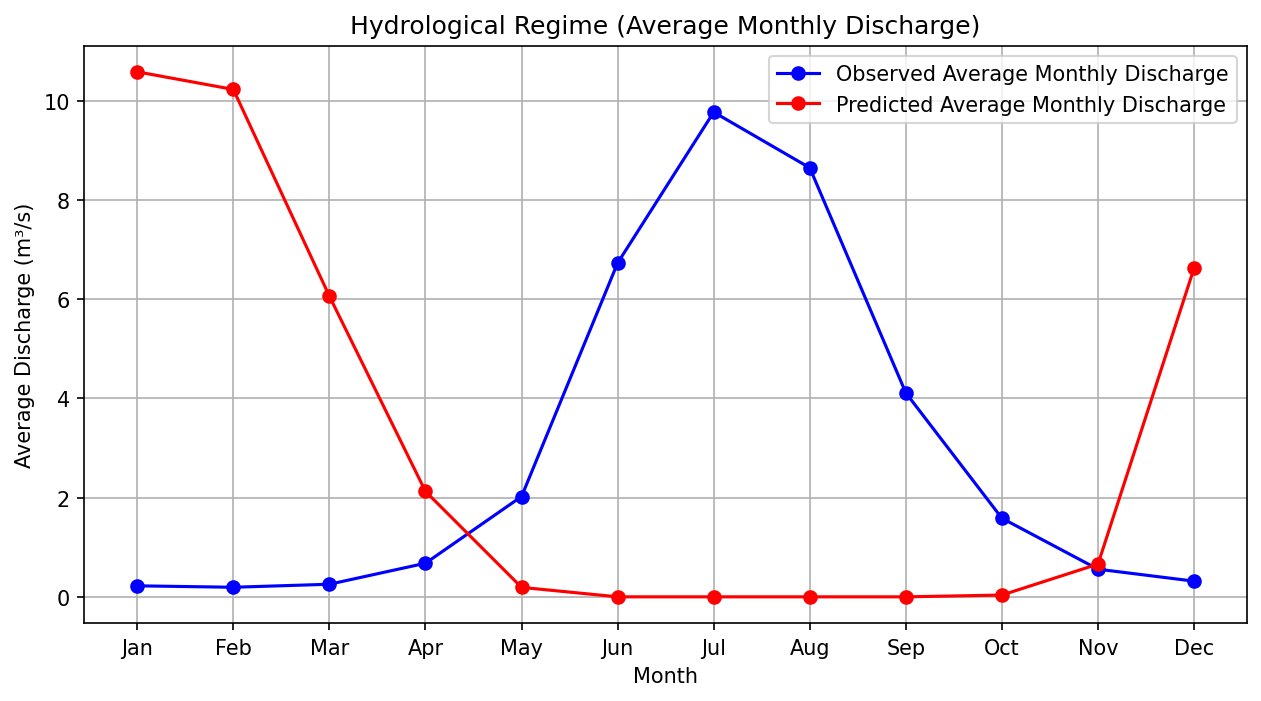

In [278]:
# Assuming filtered_test_df is your DataFrame and it ends on 2020-12-31
end_date = pd.to_datetime('2020-12-31')
num_days = len(filtered_test_df)
start_date = end_date - pd.DateOffset(days=num_days-1)

# Create a date range
date_range = pd.date_range(start=start_date, end=end_date)

# Use .loc to set the date range as a new column to the DataFrame
filtered_test_df.loc[:, 'date'] = date_range

# Check initial lengths
print("Initial lengths:")
print("filtered_test_df:", len(filtered_test_df))
print("filtered_test_Xtensor:", len(filtered_test_Xtensor))
print("filtered_test_ytensor:", len(filtered_test_ytensor))

# Ensure the lengths match
filtered_test_df = filtered_test_df.iloc[:len(filtered_test_Xtensor)]
filtered_test_ytensor = filtered_test_ytensor[:len(filtered_test_df)]

print("Lengths after ensuring match:")
print("filtered_test_df:", len(filtered_test_df))
print("filtered_test_Xtensor:", len(filtered_test_Xtensor))
print("filtered_test_ytensor:", len(filtered_test_ytensor))

# Calculate predictions
with torch.no_grad():
    predicted_discharge = model(filtered_test_Xtensor).cpu().numpy()

print("Length of predicted_discharge:", len(predicted_discharge))

# Ensure the lengths match again
predicted_discharge = predicted_discharge[:len(filtered_test_df)]

print("Length of predicted_discharge after ensuring match:", len(predicted_discharge))

# Add the predicted discharge to the DataFrame
filtered_test_df.loc[:, 'predicted_discharge'] = predicted_discharge

# Extract year and month from the date
filtered_test_df['year'] = filtered_test_df['date'].dt.year
filtered_test_df['month'] = filtered_test_df['date'].dt.month

# Calculate the average discharge for each month over the period for observed and predicted values
monthly_avg_observed = filtered_test_df.groupby('month')['discharge_vol(m3/s)'].mean()
monthly_avg_predicted = filtered_test_df.groupby('month')['predicted_discharge'].mean()

# Plot the average monthly discharge for observed and predicted values
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(monthly_avg_observed.index, monthly_avg_observed.values, marker='o', linestyle='-', color='blue', label='Observed Average Monthly Discharge')
plt.plot(monthly_avg_predicted.index, monthly_avg_predicted.values, marker='o', linestyle='-', color='red', label='Predicted Average Monthly Discharge')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Average Discharge (m³/s)')
plt.title('Hydrological Regime (Average Monthly Discharge)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

In [283]:
# Ensure the shapes match by filtering test_final_df to match the tensor shapes
test_df = test_df.iloc[:test_ytensor.shape[0]]

# Specify the catchment_id you want to plot
desired_catchment_id = '2268'

# Filter the DataFrame to include only the desired time series
filtered_test_df = test_df[test_df['catchment_id'] == desired_catchment_id]

# Create a boolean mask for the desired catchment_id
mask = test_df['catchment_id'] == desired_catchment_id

# Use the boolean mask to filter the tensors
filtered_test_ytensor = test_ytensor[mask]
filtered_test_Xtensor = test_Xtensor[mask]

# Adjust the index for plotting
plot_index = filtered_test_df.index[window_size-1:]

# Ensure the lengths match
filtered_test_ytensor = filtered_test_ytensor[:len(plot_index)]
filtered_test_Xtensor = filtered_test_Xtensor[:len(plot_index)]

# observed and predicted streafmlow series
observed = filtered_test_ytensor.cpu().numpy()
predicted = model(filtered_test_Xtensor).cpu().detach().numpy()

C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\1444802601.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_test_ytensor = test_ytensor[mask]
C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\1444802601.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_test_Xtensor = test_Xtensor[mask]


C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\350953733.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_test_ytensor = test_ytensor[mask]
C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_28580\350953733.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_test_Xtensor = test_Xtensor[mask]


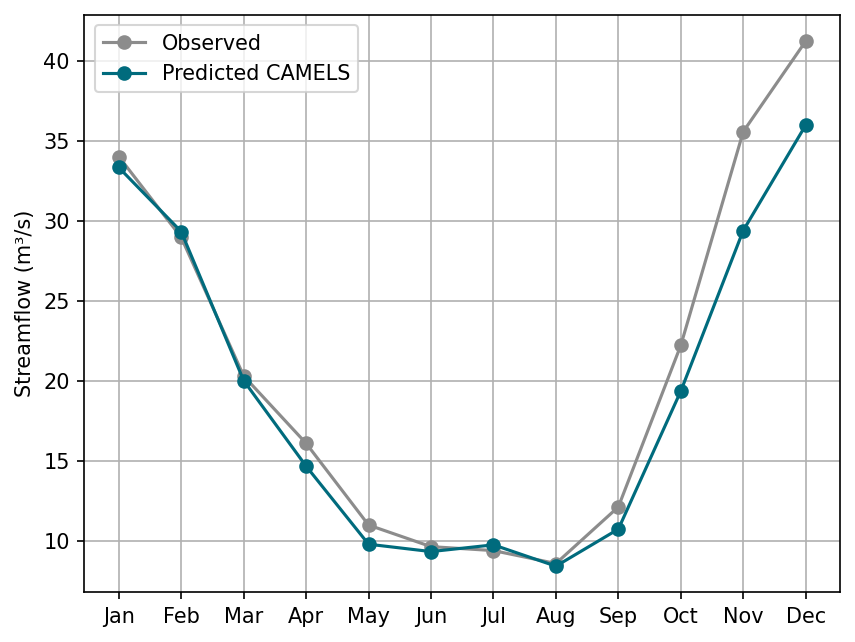

In [315]:
# Ensure the shapes match by filtering test_final_df to match the tensor shapes
test_df = test_df.iloc[:test_ytensor.shape[0]]

# Specify the catchment_id you want to plot
desired_catchment_id = '2469'

# Filter the DataFrame to include only the desired time series
filtered_test_df = test_df[test_df['catchment_id'] == desired_catchment_id]

# Create a boolean mask for the desired catchment_id
mask = test_df['catchment_id'] == desired_catchment_id

# Use the boolean mask to filter the tensors
filtered_test_ytensor = test_ytensor[mask]
filtered_test_Xtensor = test_Xtensor[mask]

# Adjust the index for plotting
plot_index = filtered_test_df.index[window_size-1:]

# Ensure the lengths match
filtered_test_ytensor = filtered_test_ytensor[:len(plot_index)]
filtered_test_Xtensor = filtered_test_Xtensor[:len(plot_index)]

# Observed and predicted streamflow series
observed = filtered_test_ytensor.cpu().numpy()
predicted = model(filtered_test_Xtensor).cpu().detach().numpy()

# Ensure the lengths match
filtered_test_df = filtered_test_df.iloc[:len(filtered_test_Xtensor)]
filtered_test_ytensor = filtered_test_ytensor[:len(filtered_test_df)]

# Calculate predictions
with torch.no_grad():
    predicted_discharge = model(filtered_test_Xtensor).cpu().numpy()

# Ensure the lengths match again
predicted_discharge = predicted_discharge[:len(filtered_test_df)]

# Add the predicted discharge to the DataFrame
filtered_test_df.loc[:, 'predicted_discharge'] = predicted_discharge

# Assuming filtered_test_df is your DataFrame and it ends on 2020-12-31
end_date = pd.to_datetime('2020-12-31')
num_days = len(filtered_test_df)
start_date = end_date - pd.DateOffset(days=num_days-1)

# Create a date range
date_range = pd.date_range(start=start_date, end=end_date)

# Use .loc to set the date range as a new column to the DataFrame
filtered_test_df.loc[:, 'date'] = date_range

# Extract year and month from the date
filtered_test_df['year'] = filtered_test_df['date'].dt.year
filtered_test_df['month'] = filtered_test_df['date'].dt.month

# Add observed and predicted streamflow to the DataFrame
filtered_test_df['observed'] = observed
filtered_test_df['predicted'] = predicted

# Calculate the average discharge for each month over the period for observed and predicted values
monthly_avg_observed = filtered_test_df.groupby('month')['observed'].mean()
monthly_avg_predicted = filtered_test_df.groupby('month')['predicted'].mean()

# Plot the average monthly discharge for observed and predicted values
plt.figure(figsize=(6.5, 5), dpi=150)
plt.plot(monthly_avg_observed.index, monthly_avg_observed.values, marker='o', linestyle='-', color='#8C8C8C', label='Observed')
plt.plot(monthly_avg_predicted.index, monthly_avg_predicted.values, marker='o', linestyle='-', color='#006B7D', label='Predicted CAMELS')

# Add labels and title
plt.xlabel('')
plt.ylabel('Streamflow (m³/s)')
plt.title('')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

In [252]:
# Look at the feature importance

# If val_X and val_y are already NumPy arrays, proceed directly. 
# Otherwise, convert them from tensors to NumPy arrays.
if isinstance(val_X, np.ndarray):
    val_features_np = val_X
    val_labels_np = val_y
else:
    val_features_np = val_X.cpu().detach().numpy()
    val_labels_np = val_y.cpu().detach().numpy()

In [254]:
def model_predict(inputs):
    # Convert inputs back to tensors if needed and move them to the correct device
    inputs_tensor = torch.FloatTensor(inputs).to(calc_device)
    model.eval()
    with torch.no_grad():
        # Get predictions from the model and convert them to NumPy
        predictions = model(inputs_tensor).cpu().numpy()
    return predictions

In [255]:
# Calculate baseline performance
baseline_predictions = model_predict(val_features_np)
baseline_mse = root_mean_squared_error(val_labels_np, baseline_predictions)

In [256]:
def manual_permutation_importance(model, X, y, metric_func, n_repeats=10):
    baseline_score = metric_func(y, model.predict(X))
    feature_importances = np.zeros(X.shape[2])  # Assuming X shape is (n_samples, sequence_length, n_features)

    # For each feature
    for i in range(X.shape[2]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            # Permute the values of the i-th feature across the sequence
            for j in range(X.shape[1]):
                np.random.shuffle(X_permuted[:, j, i])
            
            # Calculate score with permuted feature
            permuted_score = metric_func(y, model.predict(X_permuted))
            scores.append(permuted_score)

        # Importance is the difference from the baseline
        feature_importances[i] = np.mean(scores) - baseline_score

    return feature_importances

In [258]:
class PyTorchModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        # Move data to the same device as the model
        X_tensor = torch.tensor(X, dtype=torch.float32).to(next(self.model.parameters()).device)
        self.model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient tracking
            predictions = self.model(X_tensor)

        # Return predictions as NumPy array
        return predictions.cpu().numpy() if predictions is not None else None

In [259]:
# Initialize your model wrapper
wrapped_model = PyTorchModelWrapper(model)

In [260]:
# Run manual permutation importance
importances = manual_permutation_importance(
    wrapped_model,
    val_features_np,
    val_labels_np,
    root_mean_squared_error,  # Use MSE as the metric
    n_repeats=10
)

In [261]:
# Display feature importances
for i, importance in enumerate(importances):
    print(f"Feature {i + 1}: Importance score = {importance}")

Feature 1: Importance score = 3.028317089656615
Feature 2: Importance score = 1.5452162706190693
Feature 3: Importance score = 7.521385845656508
Feature 4: Importance score = 2.4603169714385817
Feature 5: Importance score = 0.18864608565984042
Feature 6: Importance score = 4.269734397983268
Feature 7: Importance score = 0.8806774226847107
Feature 8: Importance score = 6.027754283938724
Feature 9: Importance score = 0.8885747742386032


In [262]:
feature_names = [
'precipitation(mm/d)','temperature_min(°C)','temperature_mean(°C)','temperature_max(°C)','rel_sun_dur(%)','glac_area','elev_mean','area','slope_mean'
]

In [263]:
# Display feature importances with feature names
for i, importance in enumerate(importances):
    print(f"Feature '{feature_names[i]}': Importance score = {importance}")

Feature 'precipitation(mm/d)': Importance score = 3.028317089656615
Feature 'temperature_min(°C)': Importance score = 1.5452162706190693
Feature 'temperature_mean(°C)': Importance score = 7.521385845656508
Feature 'temperature_max(°C)': Importance score = 2.4603169714385817
Feature 'rel_sun_dur(%)': Importance score = 0.18864608565984042
Feature 'glac_area': Importance score = 4.269734397983268
Feature 'elev_mean': Importance score = 0.8806774226847107
Feature 'area': Importance score = 6.027754283938724
Feature 'slope_mean': Importance score = 0.8885747742386032


In [264]:
# Create a DataFrame with feature names and their importance scores
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

In [265]:
# Sort the DataFrame by importance scores in descending order
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

In [316]:
# Specify the path where you want to save the CSV file
file_path = 'C:/Users/Justine Berg/Documents/ML-course/Project/data/feature_importances_nc.csv'

# Save the sorted DataFrame as a CSV file in the specified path
feature_importances_df.to_csv(file_path, index=False)

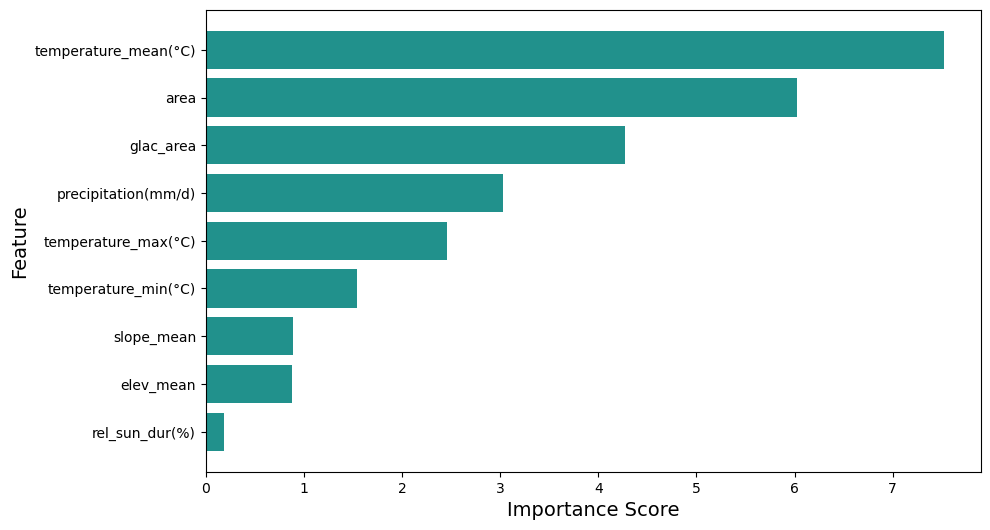

In [266]:
# Select a specific color from the viridis colormap
color = viridis(0.5)  # 0.5 is the midpoint of the colormap, you can adjust this value

# Plot the feature importances as a bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color=color)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

In [70]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.LSTM_layer = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=1, bias=True, batch_first=True)
        self.dropout_layer = nn.Dropout(p=0.5)
        self.out_layer = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    def forward(self, X):
        output, (h_n, c_n) = self.LSTM_layer(X)
        hidden_state = self.dropout_layer(h_n[-1])
        p_hat = torch.flatten(torch.relu(self.out_layer(hidden_state)))
        return p_hat

    def enable_dropout(self):
        """ Function to enable the dropout layers during test-time """
        for m in self.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()

In [73]:
def calc_nse(sim: torch.FloatTensor, obs: torch.FloatTensor, global_obs_mean: torch.FloatTensor) -> float:
    """Calculate the Nash-Sutcliff-Efficiency coefficient.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :param global_obs_mean: mean of the whole observation series
    :return: NSE value.
    """
    numerator = torch.square(sim - obs).sum()
    denominator = torch.square(obs - global_obs_mean).sum()
    nse_val = 1 - numerator / denominator

    return nse_val

In [71]:
# Define the loss function for training 
loss_func = nn.MSELoss()  # Mean Squared Error loss for regression tasks

# Instantiate our LSTM model
model = MyLSTM(input_size=9,  # Hyperparameter 1: Set to the number of input features (e.g., 10)
               hidden_size=hidden_size,  # Hyperparameter 2: Number of LSTM units (set to 16 as mentioned)
               ).to(calc_device)  # Make sure the model is on the same device as the Tensors 

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(),  # We need to pass the parameters the optimizer will optimize
                             lr=lr)  # Learning rate for the optimizer (default value)

# Define the number of epochs
num_epochs = 100  # Set the number of epochs for training (can adjust based on needs)

In [74]:
# Define empty lists that will be used to keep track of the training losses,
# validation losses, and validation metrics  
train_losses = []
val_losses = []
val_NSEs = []

#
for epoch in range(num_epochs):  # Loop over the number of epochs
    # Zero the training loss
    train_loss = 0

    # Iterate through the features and labels in the train dataloader 
    for features, labels in train_loader:
        # We need to zero the gradients associated with the model parameters.
        # We can do this directly using the optimizer
        optimizer.zero_grad()

        # Get predictions from the features using the model
        pred = model(features)

        # And use the predictions to calculate the batch loss
        batch_loss = loss_func(pred, labels)

        # Do the backpropagation from the batch_loss
        batch_loss.backward()

        # Step through the optimizer
        optimizer.step()

        # Keep track of the train loss sum. 
        # Remember to turn the tensor into a scalar!
        train_loss += batch_loss.item()

    # Calculate the number of batches in the training dataloader
    num_batches = len(train_loader)

    # Get the mean training loss over the batches
    train_loss = train_loss / num_batches

    # And append it into the list we defined to keep track of the loss
    train_losses.append(train_loss)
    
    # Calculate the validation loss and metric.
    # Use the function we defined before!
    val_loss, val_NSE = eval_model(model,  # The model
                                    val_loader,  # The dataloader
                                    loss_func,  # The loss function
                                    calc_nse)  # Replace with the actual metric function

    # Append the metric and loss values into the lists we made to keep track
    val_losses.append(val_loss)
    val_NSEs.append(val_NSE)

    # We want to save the model if it's the best version of it we've found
    # during training. If the NSE coefficient is the maximum in our training 
    # history, we'll go ahead and save the model as our best model.
    if val_NSE >= max(val_NSEs):
        torch.save(model, './best_model.pt')

    # And print out a statement to keep track of our training as we iterate
    print(f'\rEpoch: {epoch + 1}/{num_epochs},'  # Current epoch, total number of epochs
          f'train_loss: {train_loss:.4f},'  # training loss we found this epoch
          f'val_loss: {val_loss:.4f},'  # validation loss we found this epoch
          f'NSE: {val_NSE:.4f}',  # NSE coefficient we found this epoch
          end="")
   

Epoch: 100/100,train_loss: 16.0146,val_loss: 28.3330,NSE: 0.8744

In [75]:
def predict_with_uncertainty(model, features, n_iter=100):
    model.enable_dropout()
    predictions = []
    for _ in range(n_iter):
        with torch.no_grad():
            predictions.append(model(features).cpu().numpy())
    predictions = np.array(predictions)
    return predictions

# Assuming test_Xtensor is your test input tensor
n_iter = 100  # Number of forward passes
predictions = predict_with_uncertainty(model, test_Xtensor, n_iter=n_iter)

In [76]:
# Calculate mean and standard deviation of predictions
mean_predictions = predictions.mean(axis=0)
std_predictions = predictions.std(axis=0)

# Print the mean and standard deviation
print(f'Mean Predictions: {mean_predictions}')
print(f'Standard Deviation of Predictions: {std_predictions}')

Mean Predictions: [93.77619   68.805595  57.497604  ...  7.70856    7.2842674  7.0656395]
Standard Deviation of Predictions: [11.871637   8.322307   6.190782  ...  1.0367321  1.3259759  1.2989737]


In [77]:
# Calculate the loss
test_loss = loss_func(torch.tensor(mean_predictions), test_ytensor).item()

# Define the NSE calculation function
def calc_nse(observed, predicted):
    observed_mean = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - observed_mean) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

# Convert tensors to numpy arrays for NSE calculation
test_ytensor_np = test_ytensor.numpy()

# Calculate NSE
test_nse = calc_nse(test_ytensor_np, mean_predictions)

# Print the test loss and NSE
print(f'Test Loss: {test_loss:.4f}')
print(f'Test NSE: {test_nse:.4f}')

Test Loss: 23.6615
Test NSE: 0.9193


In [144]:
# Ensure the lengths match
test_df = test_df.iloc[:len(test_ytensor)]

# Specify the catchment_id you want to plot
desired_catchment_id = '2219'

# Create a boolean mask for the desired catchment_id
mask = test_df['catchment_id'] == desired_catchment_id

# Use the boolean mask to filter the DataFrame and tensors
filtered_test_df = test_df[mask]
filtered_test_ytensor = test_ytensor[mask]
filtered_test_Xtensor = test_Xtensor[mask]

C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_36396\1982647069.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_test_ytensor = test_ytensor[mask]
C:\Users\Justine Berg\AppData\Local\Temp\ipykernel_36396\1982647069.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_test_Xtensor = test_Xtensor[mask]


In [145]:
def predict_with_uncertainty(model, features, n_iter=100):
    model.enable_dropout()
    predictions = []
    for _ in range(n_iter):
        with torch.no_grad():
            predictions.append(model(features).cpu().numpy())
    predictions = np.array(predictions)
    return predictions

# Perform multiple forward passes for the filtered data
n_iter = 100  # Number of forward passes
predictions = predict_with_uncertainty(model, filtered_test_Xtensor, n_iter=n_iter)

In [146]:
# Calculate mean and standard deviation of predictions
mean_predictions = predictions.mean(axis=0)
std_predictions = predictions.std(axis=0)

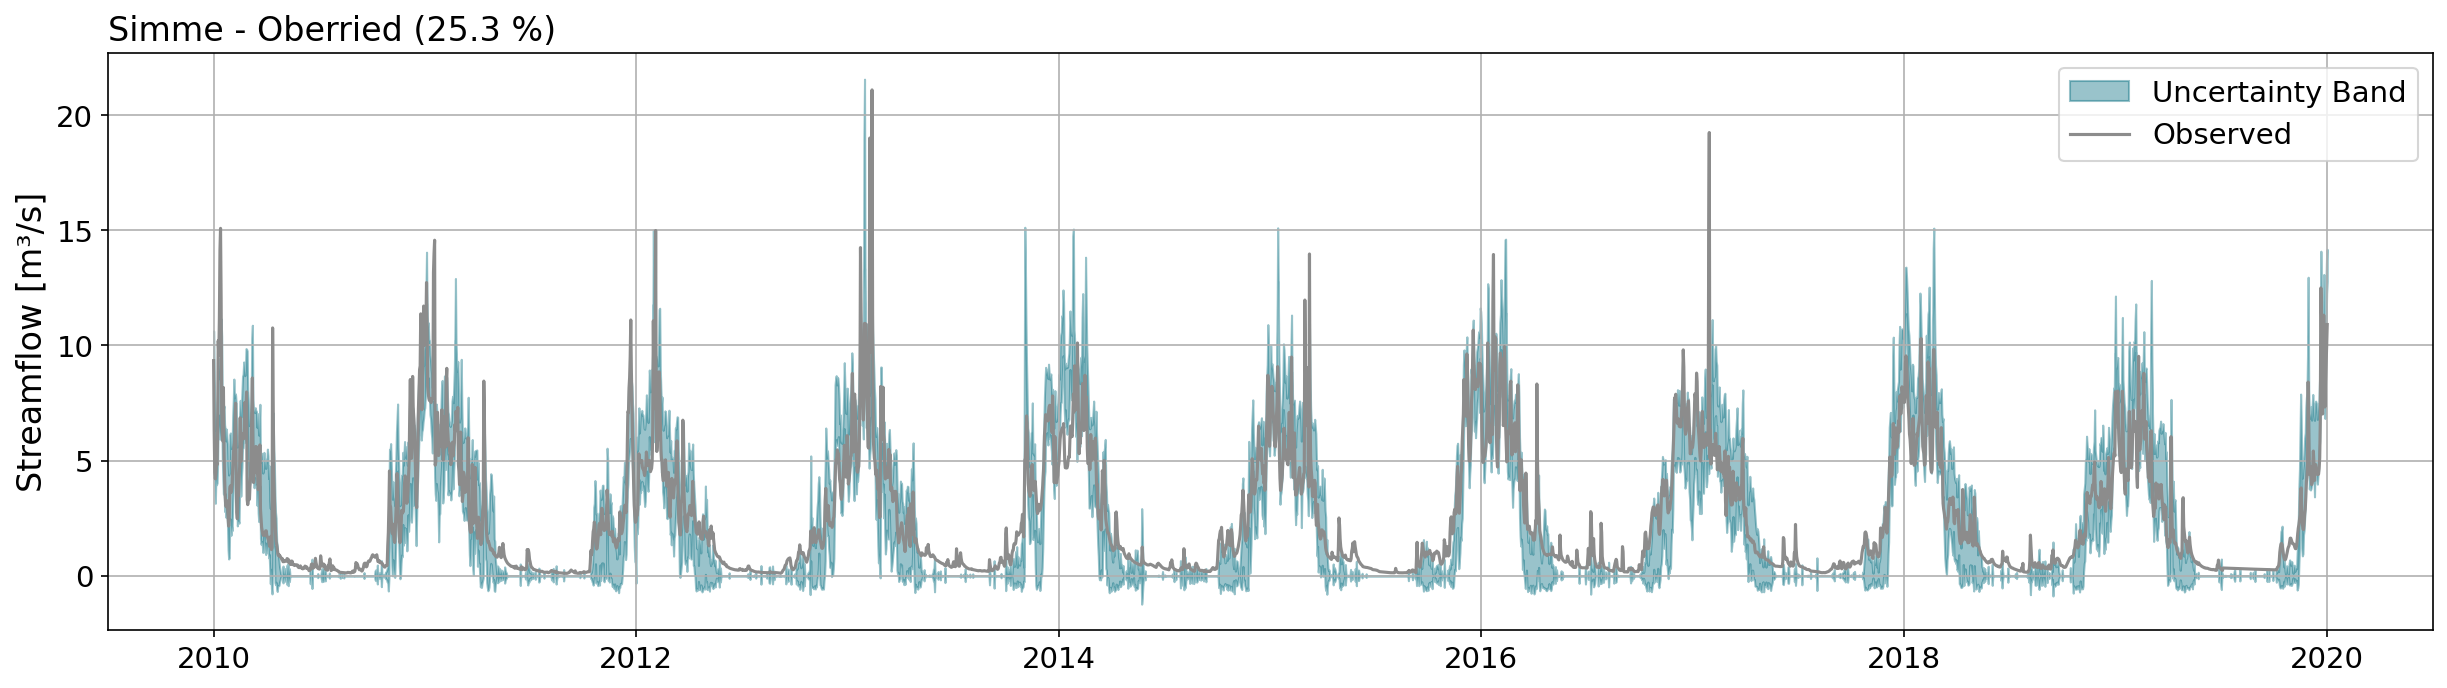

In [148]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure test_dates has the same length as mean_predictions
test_dates = pd.date_range(start='2010-01-01', periods=len(mean_predictions), freq='D')

# Plot the mean predictions
plt.figure(figsize=(20, 5), dpi=150)

# Plot the uncertainty band
plt.fill_between(test_dates, 
                 mean_predictions - std_predictions, 
                 mean_predictions + std_predictions, 
                 color='#006B7D', alpha=0.4, label='Uncertainty Band')

# Plot the actual values
#plt.plot(test_dates, mean_predictions, label='Mean prediction', color='orange')
plt.plot(test_dates, filtered_test_ytensor.cpu().numpy(), label='Observed', color='#8C8C8C')

# Add labels and title
plt.xlabel('', fontsize=16)  # No x-axis label
plt.ylabel('Streamflow [m³/s]', fontsize=16)
plt.title('Simme - Oberried (25.3 %)', fontsize=16, loc='left')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)  # Make the legend bigger

# Remove the title
# plt.title('Streamflow Predictions with Uncertainty Band')

plt.grid(True)
plt.show()



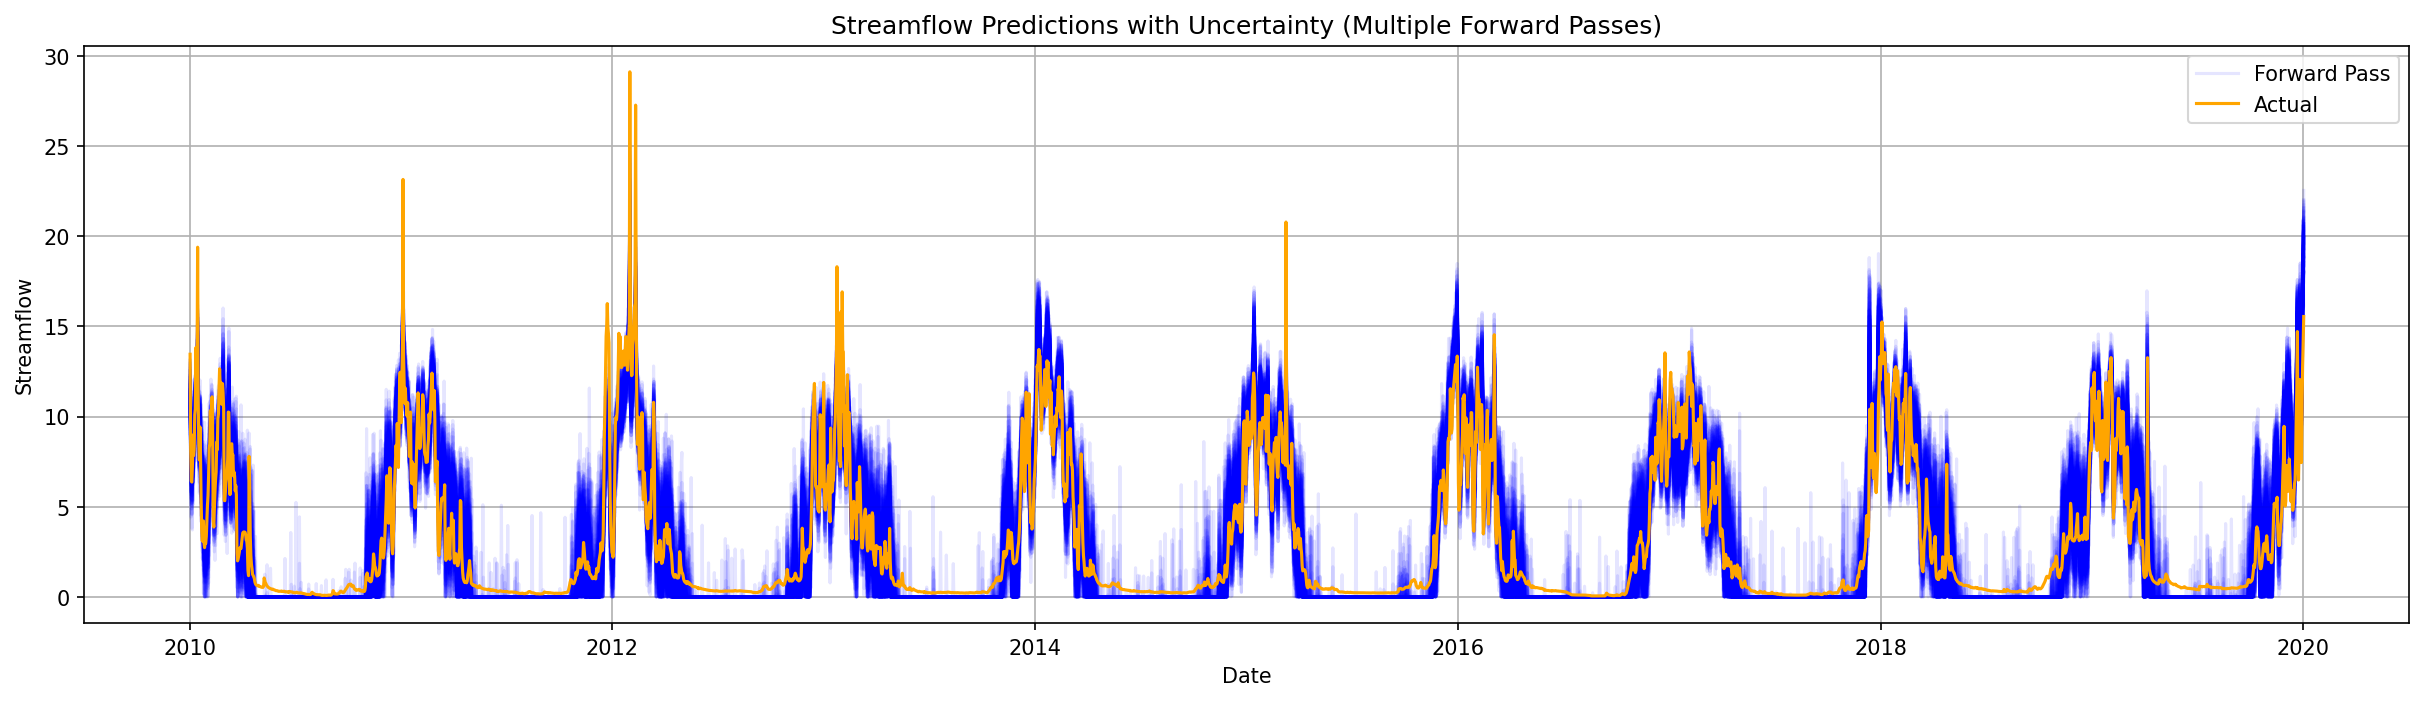

In [136]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure test_dates has the same length as the predictions
test_dates = pd.date_range(start='2010-01-01', periods=filtered_test_Xtensor.shape[0], freq='D')

# Plot the predictions of every single forward pass
plt.figure(figsize=(20, 5), dpi=150)
for i in range(n_iter):
    plt.plot(test_dates, predictions[i], color='blue', alpha=0.1, label='Forward Pass' if i == 0 else "")

# Plot the actual values
plt.plot(test_dates, filtered_test_ytensor.cpu().numpy(), label='Actual', color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Streamflow')
plt.title('Streamflow Predictions with Uncertainty (Multiple Forward Passes)')
plt.legend()
plt.grid(True)
plt.show()